/root/miniconda3/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0 Valid Acc 0.5415
Epoch 1 Valid Acc 0.7304
Epoch 2 Valid Acc 0.8583
Epoch 3 Valid Acc 0.8941
Epoch 4 Valid Acc 0.8924
Final Test Acc: 0.8893317606865416


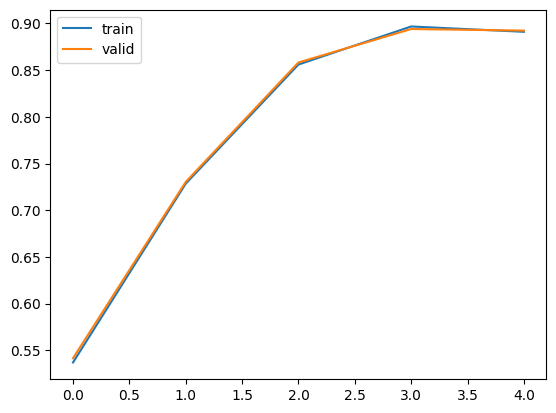

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Transformer Addition Experiment
支持 encoder-decoder / decoder-only
支持多种数据划分，用于检验泛化能力
"""

import os
import math
import random
import argparse
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

# =====================
# 数据生成
# =====================
DIGITS = "0123456789"
SPECIAL = ["+", "=", "<PAD>", "<BOS>", "<EOS>"]
itos = list(DIGITS) + SPECIAL
stoi = {ch: i for i, ch in enumerate(itos)}

PAD_IDX = stoi["<PAD>"]
BOS_IDX = stoi["<BOS>"]
EOS_IDX = stoi["<EOS>"]

def encode(seq):
    return [stoi[ch] for ch in seq]

def decode(ids):
    return "".join(itos[i] for i in ids)

def gen_addition_sample(n_digits_a, n_digits_b):
    a = random.randint(10**(n_digits_a-1), 10**n_digits_a - 1)
    b = random.randint(10**(n_digits_b-1), 10**n_digits_b - 1)
    q = f"{a}+{b}="
    ans = str(a+b)
    return q, ans

def gen_dataset(n_samples, n_digits_range=(1,3), split="random"):
    data = []
    for _ in range(n_samples):
        la = random.randint(n_digits_range[0], n_digits_range[1])
        lb = random.randint(n_digits_range[0], n_digits_range[1])
        q, ans = gen_addition_sample(la, lb)
        data.append((q, ans))
    return data

def split_dataset(data, split="random"):
    if split == "random":
        random.shuffle(data)
        n = len(data)
        return data[:int(0.8*n)], data[int(0.8*n):int(0.9*n)], data[int(0.9*n):]

    elif split == "length_extrapolation":
        # train: <=3 位；test: 4-6 位
        train = [(q,ans) for q,ans in data if max(len(q.split("+")[0]), len(q.split("+")[1].split("=")[0])) <= 3]
        test  = [(q,ans) for q,ans in data if max(len(q.split("+")[0]), len(q.split("+")[1].split("=")[0])) > 3]
        n = len(train)
        return train[:int(0.9*n)], train[int(0.9*n):], test

    elif split == "carry_split":
        def has_carry(a, b):
            s, carry = 0, 0
            while a>0 or b>0:
                s = (a%10 + b%10 + carry)
                if s>=10: return True
                carry = s//10
                a//=10; b//=10
            return False
        train, test = [], []
        for q,ans in data:
            a, b = q[:-1].split("+")
            if has_carry(int(a), int(b)):
                test.append((q,ans))
            else:
                train.append((q,ans))
        n = len(train)
        return train[:int(0.9*n)], train[int(0.9*n):], test
    else:
        raise ValueError("unknown split")

def batchify(data, batch_size, device):
    random.shuffle(data)
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        qs = []; ans_in = []; ans_out=[]
        for q, ans in batch:
            q_ids = encode(q)
            a_ids = [BOS_IDX] + encode(ans) + [EOS_IDX]
            qs.append(q_ids)
            ans_in.append(a_ids[:-1])
            ans_out.append(a_ids[1:])
        maxq = max(len(x) for x in qs)
        maxa = max(len(x) for x in ans_in)
        qs = [x+[PAD_IDX]*(maxq-len(x)) for x in qs]
        ans_in = [x+[PAD_IDX]*(maxa-len(x)) for x in ans_in]
        ans_out = [x+[PAD_IDX]*(maxa-len(x)) for x in ans_out]
        yield (torch.tensor(qs, dtype=torch.long, device=device),
               torch.tensor(ans_in, dtype=torch.long, device=device),
               torch.tensor(ans_out, dtype=torch.long, device=device))

# =====================
# 模型
# =====================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x, offset=0):
        return x + self.pe[:, offset:offset+x.size(1)]

class TransformerAddition(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=3, mode="encdec", max_len=100):
        super().__init__()
        self.mode = mode
        self.emb = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model, max_len)
        if mode=="encdec":
            enc_layer = nn.TransformerEncoderLayer(d_model, nhead, 256)
            dec_layer = nn.TransformerDecoderLayer(d_model, nhead, 256)
            self.encoder = nn.TransformerEncoder(enc_layer, num_layers)
            self.decoder = nn.TransformerDecoder(dec_layer, num_layers)
        else:
            layer = nn.TransformerEncoderLayer(d_model, nhead, 256)
            self.transformer = nn.TransformerEncoder(layer, num_layers)
        self.out = nn.Linear(d_model, vocab_size)

    def forward_encdec(self, src, tgt):
        src_emb = self.pos(self.emb(src))
        memory = self.encoder(src_emb.transpose(0,1))
        tgt_emb = self.pos(self.emb(tgt))
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_emb.size(1)).to(tgt.device)
        out = self.decoder(tgt_emb.transpose(0,1), memory, tgt_mask=tgt_mask)
        return self.out(out.transpose(0,1))

    def forward_dec(self, src, tgt_in):
        # 输入拼接：[query, tgt_in]
        seq = torch.cat([src, tgt_in], dim=1)
        emb = self.pos(self.emb(seq))
        mask = nn.Transformer.generate_square_subsequent_mask(seq.size(1)).to(seq.device)
        out = self.transformer(emb.transpose(0,1), mask)
        out = self.out(out.transpose(0,1))
        # 只取 tgt 部分的输出
        return out[:, src.size(1):, :]



    def forward(self, src, tgt):
        if self.mode=="encdec":
            return self.forward_encdec(src, tgt)
        else:
            return self.forward_dec(src, tgt)


# =====================
# 训练 & 评估
# =====================
def evaluate(model, data, device, batch_size=64):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for q, ans_in, ans_out in batchify(data, batch_size, device):
            logits = model(q, ans_in)
            pred = logits.argmax(-1)
            mask = (ans_out!=PAD_IDX)
            total += mask.sum().item()
            correct += ((pred==ans_out) & mask).sum().item()
    return correct/total

def train(model, train_data, valid_data, device, args):
    opt = optim.Adam(model.parameters(), lr=args.lr)
    loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    train_accs, valid_accs = [], []
    for epoch in range(args.epochs):
        model.train()
        for q, ans_in, ans_out in batchify(train_data, args.batch_size, device):
            opt.zero_grad()
            logits = model(q, ans_in)
            loss = loss_fn(logits.reshape(-1, logits.size(-1)), ans_out.reshape(-1))
            loss.backward()
            opt.step()
        acc = evaluate(model, valid_data, device)
        train_accs.append(evaluate(model, train_data[:1000], device))
        valid_accs.append(acc)
        print(f"Epoch {epoch} Valid Acc {acc:.4f}")
    return train_accs, valid_accs

# =====================
# 主程序
# =====================
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--mode", choices=["encdec","dec-only"], default="encdec")
    parser.add_argument("--split", choices=["random","length_extrapolation","carry_split"], default="random")
    parser.add_argument("--epochs", type=int, default=10)
    parser.add_argument("--batch_size", type=int, default=64)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--device", default="cuda" if torch.cuda.is_available() else "cpu")
    args = parser.parse_args()

    data = gen_dataset(50000, (1,5))
    train_data, valid_data, test_data = split_dataset(data, args.split)

    model = TransformerAddition(len(itos), mode=args.mode).to(args.device)
    train_accs, valid_accs = train(model, train_data, valid_data, args.device, args)

    test_acc = evaluate(model, test_data, args.device)
    print("Final Test Acc:", test_acc)

    # 绘图
    os.makedirs("results", exist_ok=True)
    plt.plot(train_accs,label="train")
    plt.plot(valid_accs,label="valid")
    plt.legend(); plt.savefig("results/curve.png")

if __name__ == "__main__":
    import sys
    sys.argv = ["script.py", "--mode", "dec-only", "--split", "random", "--epochs", "5"]
    main()
